In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

#Criando um DataFrame pandas com a tabela csv do hidroweb
#enconding - transformar dados em um formato especifico
#index_col - primeira coluna não é index da tabela (false)
#skiprows - pular as 13 linhas iniciais para formar a tabela (Evitando o cabeçalho do hidroweb)
local_do_arquivo="65310000_Vazoes.csv"

df=pd.read_csv(local_do_arquivo, delimiter=';', encoding='ISO-8859-1', index_col=False, skiprows=13)

#alterar separador decimal
df=df.replace(',', '.', regex = True)

#convertendo os valores do df para valores númericos e arredondado eles para 2 casas decimais
df = df.apply(pd.to_numeric, errors='ignore')
df=df.round(2)

C:\Users\PersioPuertasGarciaL\AppData\Local\Temp\ipykernel_7840\2340429170.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [4]:
#definindo as colunas do arquivo original que serão utilizadas
lista_colunas=['Data', 'Vazao01', 'Vazao02', 'Vazao03',
       'Vazao04', 'Vazao05', 'Vazao06', 'Vazao07', 'Vazao08', 'Vazao09',
       'Vazao10', 'Vazao11', 'Vazao12', 'Vazao13', 'Vazao14', 'Vazao15',
       'Vazao16', 'Vazao17', 'Vazao18', 'Vazao19', 'Vazao20', 'Vazao21',
       'Vazao22', 'Vazao23', 'Vazao24', 'Vazao25', 'Vazao26', 'Vazao27',
       'Vazao28', 'Vazao29', 'Vazao30', 'Vazao31']

#apenas os dados das colunas presentes na lista
df=df[lista_colunas]

#indicando para o pandas o formato em que a coluna Data está para que ele consiga a entender, convertando para o seu formato padrão (y/m/d)
df['Data']=pd.to_datetime(df['Data'], format='%d/%m/%Y')

In [5]:
#criando listas vazias
lista_vazao=[]
lista_data=[]

#iteração a partir do comprimento total da tabela
#para cada coluna Data, obtem-se o ano e o mes
for n in range(0,len(df)):
    
    month_info=df['Data'][n].month  
    year_info=df['Data'][n].year
        
    #utilizando a biblioteca calendar para extrair qual é a data do último dia do mês
    #e fazer a iteração sem errar a localizacao de cada valor diário de vazão
    for day in range(0,calendar.monthrange(year_info, month_info)[1]):
            VAZAO=df.iloc[[n]][df.columns[day+1]]
        	
            #bliblioteca Datetime para criar a data da vazao year/month/day
            DATA=datetime.datetime(year_info, month_info, day+1)
            
            #adicionar os resultados na lista
            lista_vazao.append(float(VAZAO.values[0]))
            lista_data.append(DATA)

#criando a tabela final 
df=pd.DataFrame(lista_data, columns=['Data'])
df['Data']=pd.to_datetime(df['Data'], format='%d/%m/%Y')

df['Vazao']=lista_vazao

df=df.sort_values(by='Data').reset_index(drop=True)

#para converter ao formato dd/mm/yyyy
#df['Data'] = pd.to_datetime(df['Data']).dt.strftime('%d/%m/%Y')

#exportar csv, se precisar
nome_do_csv="vazoes.csv"
df.to_csv(nome_do_csv)

In [6]:
#verificar e substituir valores ausentes pela média
df['Vazao'].fillna(df['Vazao'].mean(), inplace=True)

#estatísticas descritivas
estatisticas_descritivas = df['Vazao'].describe()
print("Estatísticas Descritivas:")
print(estatisticas_descritivas)

#média mensal de longo termo
df['Mes'] = df['Data'].dt.month
media_mensal = df.groupby('Mes')['Vazao'].mean()
print("\nMédia Mensal:")
print(media_mensal)

Estatísticas Descritivas:
count    34213.000000
mean       493.617766
std        449.353684
min         53.950000
25%        198.090000
50%        344.920000
75%        631.700000
max       5072.610000
Name: Vazao, dtype: float64

Média Mensal:
Mes
1     477.731492
2     508.457000
3     469.856091
4     353.245885
5     409.986267
6     529.455213
7     529.981819
8     457.767388
9     519.278206
10    699.760323
11    525.694331
12    440.284166
Name: Vazao, dtype: float64


C:\Users\PersioPuertasGarciaL\AppData\Local\Temp\ipykernel_7840\2335655922.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Vazao'].fillna(df['Vazao'].mean(), inplace=True)


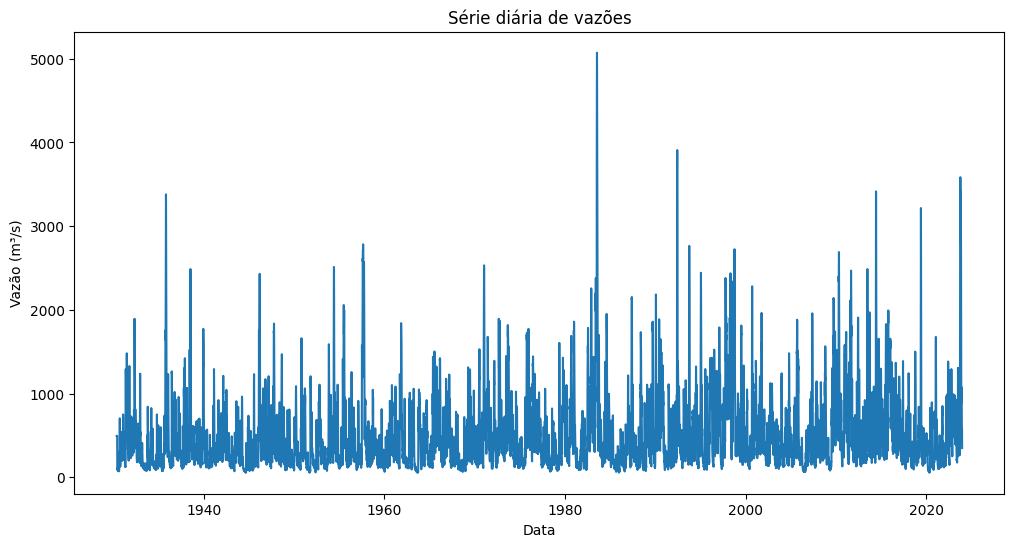

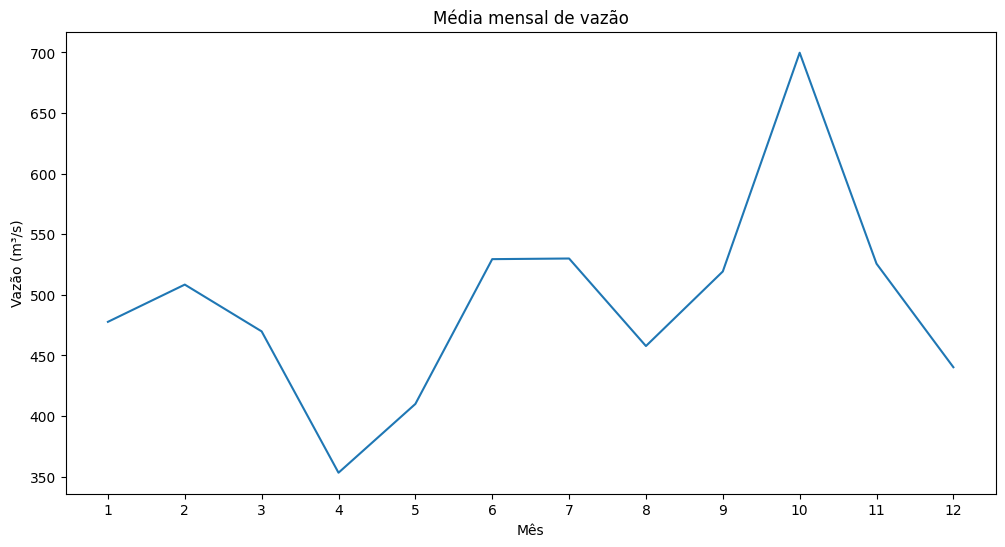

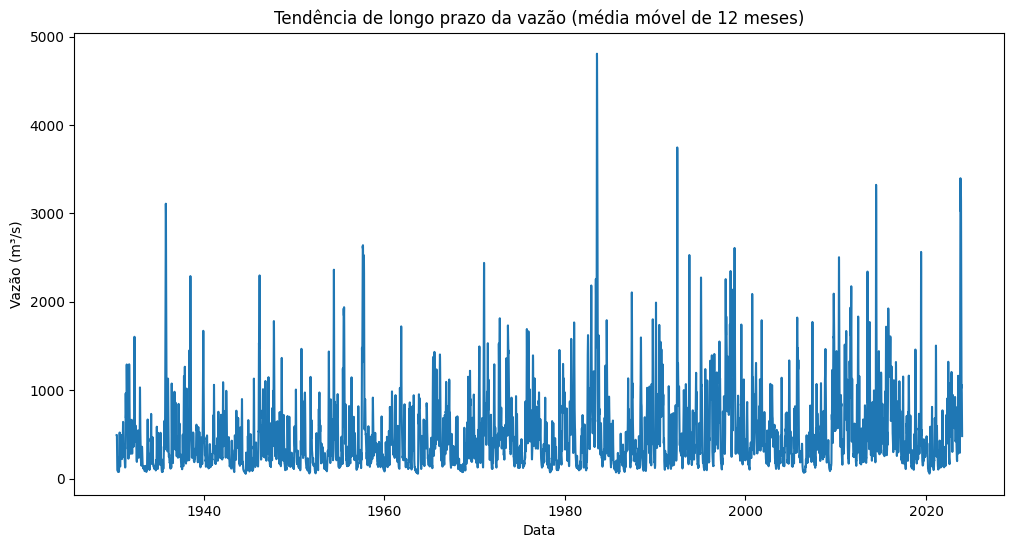

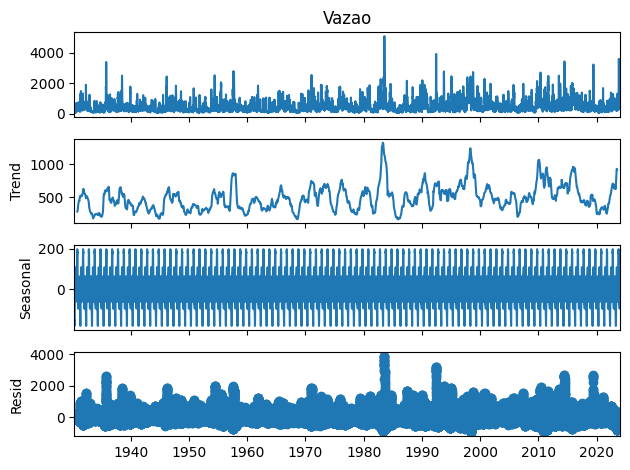

In [7]:
#plot da serie de vazão
plt.figure(figsize=(12, 6))
sns.lineplot(x='Data', y='Vazao', data=df)
plt.title('Série diária de vazões')
plt.xlabel('Data')
plt.ylabel('Vazão (m³/s)')
plt.show()

#média mensal de longo termo
df['Mes'] = df['Data'].dt.month
media_mensal = df.groupby('Mes').mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=media_mensal.index, y=media_mensal['Vazao'])
plt.title('Média mensal de vazão')
plt.xlabel('Mês')
plt.ylabel('Vazão (m³/s)')
plt.xticks(range(1, 13))
plt.show()


#média móvel de 12 meses para suavizar as séries - visualizar tendencia de forma simples para series com muito ruido
df['Vazao_ma'] = df['Vazao'].rolling(window=12).mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x='Data', y='Vazao_ma', data=df)
plt.title('Tendência de longo prazo da vazão (média móvel de 12 meses)')
plt.xlabel('Data')
plt.ylabel('Vazão (m³/s)')
plt.show()

#decomposição da serie em tendencia, sazonalidade e residuo
#tendencia: componente de baixa frequencia que captura variações de longo prazo e possui alterações lentas
#sazonalidade: componente com frequencia alta e periodicidade conhecida
#residuo: o que sobra após a tendencia e a sazonalidade
decompose_vazao = seasonal_decompose(df.set_index('Data')['Vazao'], model='additive', period=365)
decompose_vazao.plot()
plt.show()


<Axes: >

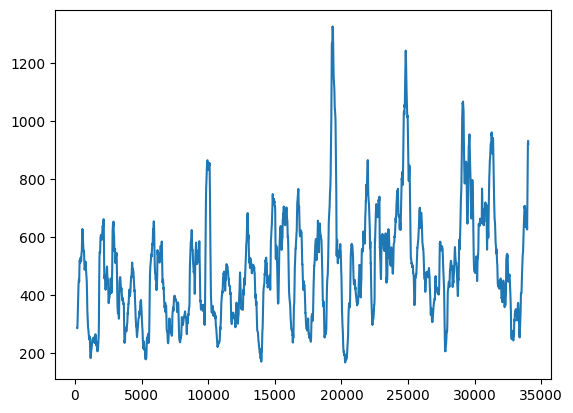

In [23]:
#exemplo com valores de tendencia
tendencias = pd.DataFrame({
    'Data': decompose_vazao._trend.index,
    'Vazao_tendencia': decompose_vazao._trend.values
})

tendencias["Vazao_tendencia"].plot()